# Perceptron

## Note to my future self


The important concepts in this notebook are based off 
- of Section 3.5, The perceptron, 
- of Chapter 3, Single-layer Networks, 
- of Bishop's Neural Networks for Pattern Recognition (1995). 

Tasks accomplished in this notebook:
- Part I: Train a perceptron using the pattern-by-pattern gradient-descent update rule (Equation 3.68, Page 100)
- Part II: Demonstrate the Perceptron convergence theorem (Section 3.5.3, Page 100) in action
- Part III: When data set is not linearly separable (Second paragraph, Page 103)

## Imports

In [2]:
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

## Part I - Train a Perceptron

Generate samples from two clusters, each with a standard deviation of 0.3.

In [3]:
samps, labels = make_blobs(
    n_samples=250, 
    n_features=2, 
    centers=np.array([[-1, 0], [1, 0]]), 
    cluster_std=0.3,
    center_box=(-10.0, 10.0), 
    shuffle=True, 
    random_state=324
)

Change 0 labels to -1 labels.

In [4]:
labels[labels == 0] = -1  # in accordance with the threshold activation function (Equation 3.66, Page 99)

In [8]:
labels[:10]  # sanity check

array([ 1, -1, -1,  1,  1,  1,  1, -1, -1, -1])

"Defining an extra basis function $\phi_0$ whose activation is permanently set to +1, together with a corresponding bias parameteres $w_0$." (Last paragraph, Page 98)

In [18]:
F1, F2 = np.s_[:,0], np.s_[:,1]  # a simple way to slice more elegantly

Visualize. There is one thing to look out for. "One of the difficulties with the perceptron learning rule  is that, if the data set happens not to be linearly separable, then the learning algorithm will never terminate. Furthermore, if we arbitrarily stop the learning process there is no guarantee that the weight vector found will generalize well for new data." (2nd Paragraph, Page 103) For our case, the data set is clearly linearly separable and hence does not suffer from this problem.

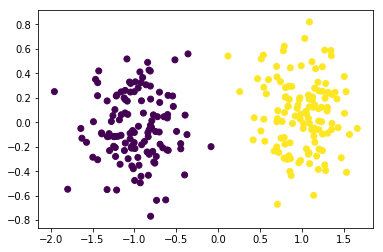

In [19]:
plt.scatter(samps[F1], samps[F2], c=labels)
plt.show()

In [20]:
samps_with_ones = np.hstack([
    samps, 
    np.ones(len(samps)).reshape(len(samps), 1)  # \phi_0's
])

In [21]:
samps_with_ones[:3]  # sanity check

array([[ 0.79442375,  0.08021988,  1.        ],
       [-0.39928129, -0.43023189,  1.        ],
       [-1.01204752, -0.37955748,  1.        ]])

Now, we discuss the training procedure.

Define the Perceptron class.

In [80]:
class Perceptron:
    
    def __init__(self):
        # initial guess
        # I chose a strange initial guess so that the perceptron does not converge quickly \
        # so that I could actually see the loss decreasing over a dozens of (not just a few) weight updates
        self.w = np.array([[-50.0], [40.0], [-23.0]])  
        self.w_histories = [self.w.copy()]
        
    @staticmethod
    def step_func(input):
        """
        Activation function used by the Perceptron. (Page 99)
        """
        if input >= 0: return 1
        elif input < 0: return -1
        
    def linear_combination(self, samp_vec):
        """
        Lenght of the projection of sample vector onto the weight vector.
        Equivalent to the orthogonal distance from the decision-boundary hyperplane.
        """
        return float(self.w.T @ samp_vec)
        
    def discriminant(self, samp_vec):
        """
        Output of the Perceptron.
        """
        activation = self.step_func(
            self.linear_combination(samp_vec)
        )
        return activation
    
    def increment_weight(self, delta):
        self.w = self.w.copy() + delta
        self.w_histories.append(self.w)
        
    def hyperplane(self, xs, w):
        ys = (- w[0]) / w[1] * xs - w[2] / w[1]
        return ys
    
    def hyperplane_histories(self, xs, num_recent=10, num_stride=1):
        hyperplanes = []
        for w in self.w_histories[-num_recent::num_stride]:
            hyperplanes.append(self.hyperplane(xs, w))
        return hyperplanes

Train the perceptron. Re-compute loss after each weight update.

In [81]:
p = Perceptron()
losses = []

for i in tqdm_notebook(range(10)):
    
    for samp, label in zip(samps_with_ones, labels):
        
        samp_vec = samp.reshape(3, 1)
        
        if p.discriminant(samp_vec) * label < 0:  # misclassified
            
            # multiplying by label is just a compact way to express: 
            # if 
            # p.discriminant(samp_vec) > 0 and label < 0
            # or
            # p.discriminant(samp_vec) < 0 and label > 0
            
            p.increment_weight(samp_vec * label)  # guaranteed to reduce loss on this example
            
            # ========== proof (Equation 3.69, Page 100) ==========
            # w_new.T @ samp_vec : interpreted as the new magnitude of mistake
            #
            # if p.discriminant(samp_vec) > 0 and label < 0:
            #     w_new = w_old - samp_vec
            #     reduces error because:
            #     -> w_new.T @ samp_vec 
            #     -> = (w_old - sample_vec).T @ sample_vec
            #     -> = w_old @ sample_vec - sample_vec.T @ sample_vec (positive)
            #     -> < w_old @ sample_vec (old magnitude of mistake)
            #
            # elif p.discriminant(samp_vec) < 0 and label > 0:
            #     ... works in a similar way ...
            
            # loss computation only when w is updated
            
            loss = 0.0
    
            for samp, label in zip(samps_with_ones, labels):

                samp_vec = samp.reshape(3, 1)

                if p.discriminant(samp_vec) * label < 0:  # misclassified
                    loss -= p.linear_combination(samp_vec) * label
                    
            losses.append(loss)

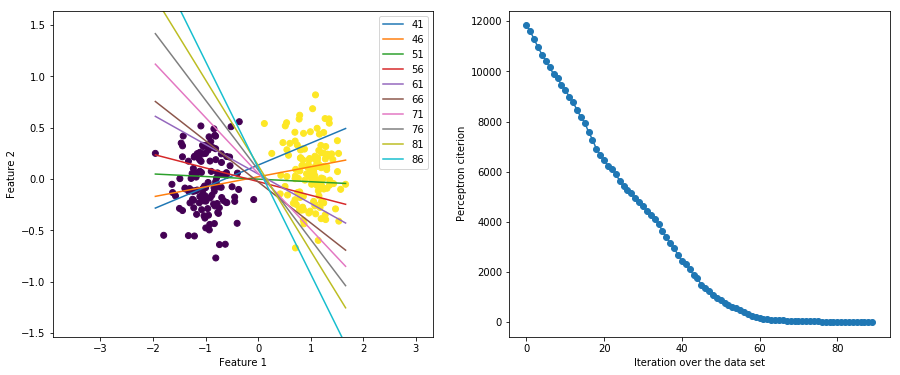

In [97]:
fig = plt.figure(figsize=(15, 6))

# figure 1

fig.add_subplot(121)

plt.scatter(samps[F1], samps[F2], c=labels)

y_lower, y_upper = samps[F2].min(), samps[F2].max()
x_lower, x_upper = samps[F1].min(), samps[F1].max()

xs = np.array([x_lower, x_upper])

kNUM_RECENT = 50
kNUM_STRIDE = 5
hyperplane_histories = p.hyperplane_histories(xs, num_recent=kNUM_RECENT, num_stride=kNUM_STRIDE)
num_histories = len(p.w_histories)

for i, hyperplane in enumerate(hyperplane_histories):
    plt.plot(xs, hyperplane, label=f'After {num_histories - kNUM_RECENT + i * kNUM_STRIDE}')

plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
    
plt.xlim(x_lower * 2, x_upper * 2)
plt.ylim(y_lower * 2, y_upper * 2)

# figure 2

fig.add_subplot(122)

plt.scatter(np.arange(len(losses)), losses)
plt.plot(losses)

plt.xlabel('Iteration over the data set')
plt.ylabel('Perceptron citerion')

plt.show()

In [68]:
p.w

array([[30.06211668],
       [24.50155061],
       [-3.        ]])

## Part II - Perceptron convergence theorem